In [18]:
# %load 5vib.py
import poscar
import sys
import numpy as np
import scc_lib
import os
import matplotlib.pyplot as plt
import random
import logging
import matplotlib
from sympy import *
from sympy.plotting import plot

matplotlib.rcParams["backend"] = "PDF"

In [ ]:
def get_energy(path):
    with open(path + "/OSZICAR", "r") as f:
        # match_result=re.search("E0=\s+([\+\-\.\dE]+)",f.readlines()[-1])
        # if match_result:
        #     return float(match_result.group(1))
        # print(path, end=" ")
        last2lines = f.readlines()[-2:]
        if "E0" in last2lines[-1]:
            # print(float(last2lines[-1].split("E0= ")[1].split(" ")[0]))
            return float(last2lines[-1].split("E0= ")[1].split(" ")[0])
        elif "E+" in last2lines[-1]:
            # print(float([i for i in last2lines[-1].split(" ") if len(i) > 1 and i[:2] == "-0"][0]))
            return float([i for i in last2lines[-1].split(" ") if len(i) > 1 and i[:2] == "-0"][0])
        elif "E+" in last2lines[-2]:
            # print(float([i for i in last2lines[-2].split(" ") if len(i) > 1 and i[:2] == "-0"][0]))
            return float([i for i in last2lines[-2].split(" ") if len(i) > 1 and i[:2] == "-0"][0])
        else:
            return False


def read_yaml(path):
    freq = []
    mode = []
    mass = []

    with open(path, "r") as f:
        while True:
            line = f.readline()
            if "natom:" in line:
                natom = int(line.strip().split(" ")[-1])
                break

        while True:
            line = f.readline()
            if line == "\n":
                break
            elif "mass:" in line:
                mass.append(float(line.strip().split(" ")[-1]))

        while True:
            line = f.readline()
            if "band:" in line:
                break

        while True:
            line = f.readline()
            if line == "\n":
                break
            else:
                freq.append(float(f.readline().strip().split()[1]) * 4.135669057 / 1e3)  # THz to eV
                f.readline()
                mode.append([])
                for a in range(natom):
                    f.readline()
                    mode[-1].append(
                        np.array(
                            [float(f.readline().replace(",", "").strip().split()[2]) for _ in range(3)]
                        )
                    )

        modewom = np.array([[k / np.sqrt(j) for j, k in zip(mass, i)] for i in mode])

    return mass, freq, mode, modewom


def mode_sub(*args):
    # run jobs, should run read_yaml first
    nmode, displacement, name = args
    pos = ground.copy()
    pos.position = modewom[nmode]
    for j in [-1, 1]:
        if f"{name}{nmode}_{displacement * j}" not in os.listdir():
            (ground + pos * (j * displacement)).write(f"z{nmode}_{displacement * j}")
            scc_lib.linux_command(
                f"mkdir {name}{nmode}_{displacement * j}; "
                f"mv z{nmode}_{displacement * j} {name}{nmode}_{displacement * j}/POSCAR; "
                f"cp INCAR POTCAR KPOINTS WAVECAR {name}{nmode}_{displacement * j};"
                f"cd {name}{nmode}_{displacement * j}; "
                f"0run -q {random.choice(['smallopa', 'smallopa', 'smallib'])};"
                f"cd ..;")
    return None


def expand_sub(lattice):
    # run jobs, should run read_yaml first
    pos = ground.copy()
    pos.c2d()
    pos.lattice = pos.lattice / pos.lattice[0][0] * (lattice / 100 + 10) / 3 * 4
    if f"z{lattice}" not in os.listdir():
        pos.write(f"z{lattice}")
        scc_lib.linux_command(
            f"mkdir s{lattice}; "
            f"mv z{lattice} s{lattice}/POSCAR; "
            f"cp INCAR POTCAR KPOINTS WAVECAR s{lattice};"
            f"cd s{lattice}; "
            f"0run -q {random.choice(['smallopa'])};"
            f"cd ..;")
    return None


def random_sub(displacement, label):
    # run jobs, should run read_yaml first
    if f"r{displacement}_{label}" not in os.listdir():
        scc_lib.linux_command(f"mkdir r{displacement}_{label}; ")
        ground.random_distort(displacement).write(f"r{displacement}_{label}/POSCAR")
        scc_lib.linux_command(f"cp INCAR POTCAR KPOINTS WAVECAR r{displacement}_{label};"
                              f"cd r{displacement}_{label}; "
                              f"0run -q {random.choice(['smallopa'])};"
                              f"cd ..;")
    return None


def read_outcar(path, atom_list, natom, only_total=True, vector=np.array([-1, -1, -1]), multi=100, printlevel=False):
    vector = vector / np.linalg.norm(vector)

    Fermi_contact_term_dict = {}
    total_contribution_dict = {}
    # for i in atom_list:
    #     dipolar_contribution[i] = np.zeros(9)
    #     dipolar_contribution[i].resize((3, 3))

    with open(path + "/OUTCAR", "r") as f:
        lines = f.readlines()

        # read Atot of Fermi contact
        for i in range(len(lines))[::-1]:
            if "Fermi contact (isotropic) hyperfine coupling parameter (MHz)" in lines[i]:
                flag = i
                break
        for atom in atom_list:
            try:
                Fermi_contact_term = float(lines[flag + 3 + atom][-10:])
            except:
                print(path, "can\'t convert Fermi_contact_term to float")
            Fermi_contact_term_dict[atom] = Fermi_contact_term

        # read Adipolar
        for i in range(len(lines))[flag + 3 + natom + 1:]:
            if "Dipolar hyperfine coupling parameters (MHz)" in lines[i]:
                flag = i
                break
        for atom in atom_list:
            try:
                dipolar_contribution = [float(lines[flag + 3 + atom][6 + i * 10:16 + i * 10]) for i in range(6)]
            except:
                print(path, "can\'t convert dipolar_contribution to float")

            total_contribution = np.array(
                [[dipolar_contribution[0], dipolar_contribution[3], dipolar_contribution[4]],
                 [dipolar_contribution[3], dipolar_contribution[1], dipolar_contribution[5]],
                 [dipolar_contribution[4], dipolar_contribution[5], dipolar_contribution[2]]]) + \
                                 np.diag([Fermi_contact_term_dict[atom] for i in range(3)])
            if printlevel:
                logging.info(f"{atom} mat {total_contribution}")
            Fermi_contact_term_dict[atom] /= multi
            total_contribution = np.linalg.norm(vector.dot(total_contribution)) / multi * np.sign(
                total_contribution[0][0])
            if printlevel:
                logging.info(f"{atom} value {total_contribution}")

            total_contribution_dict[atom] = total_contribution

    if only_total:
        return total_contribution_dict
    else:
        return total_contribution_dict, Fermi_contact_term_dict


def read_Cq(path):
    flag = 0
    with open(path + "/OUTCAR", "r") as f:
        lines = f.readlines()
        for i in range(len(lines))[::-1]:
            if "ion       Cq(MHz)       eta       Q (mb)" in lines[i]:
                flag = i
                break
        return 4 / 5 * float([i for i in lines[flag + 2].split(" ") if i][1])

In [ ]:
def Einstein_model(mode):
    T, X, theta=symbols("T X theta")
    # 0-1000K
    C1= np.array([0.0096, 0.2656, 2.6799, 2.3303])* 1e-6
    C2 = np.array([159.3, 548.5, 1237.9, 2117.8])
    Einstein_function=X * (theta/T) ** 2 * E ** (theta/T) / (E ** (theta/T) - 1) ** 2
    integrated_Einstein_function=integrate(Einstein_function,(T))
    # Einstein_model(1) alpha 0-5 is not good
    # Einstein_model(2) delta L/L(T) 0-2 is not good
    return {0: Einstein_function,
           1: lambdify(T,sum([Einstein_function.subs(X,C1[n]).subs(theta,C2[n]) for n in range (4)]),"numpy"),
           2: lambdify(T,sum([integrated_Einstein_function.subs(X,C1[n]).subs(theta,C2[n]) for n in range (4)]),"numpy")}[mode]

<lambdifygenerated-5>:2: RuntimeWarning: divide by zero encountered in true_divide
  return (10.451574560252*exp(2117.8/T)/(T**2*(exp(2117.8/T) - 1)**2) + 4.106669139159*exp(1237.9/T)/(T**2*(exp(1237.9/T) - 1)**2) + 0.0799063576*exp(548.5/T)/(T**2*(exp(548.5/T) - 1)**2) + 0.000243614304*exp(159.3/T)/(T**2*(exp(159.3/T) - 1)**2))
<lambdifygenerated-5>:2: RuntimeWarning: overflow encountered in exp
  return (10.451574560252*exp(2117.8/T)/(T**2*(exp(2117.8/T) - 1)**2) + 4.106669139159*exp(1237.9/T)/(T**2*(exp(1237.9/T) - 1)**2) + 0.0799063576*exp(548.5/T)/(T**2*(exp(548.5/T) - 1)**2) + 0.000243614304*exp(159.3/T)/(T**2*(exp(159.3/T) - 1)**2))
<lambdifygenerated-5>:2: RuntimeWarning: overflow encountered in square
  return (10.451574560252*exp(2117.8/T)/(T**2*(exp(2117.8/T) - 1)**2) + 4.106669139159*exp(1237.9/T)/(T**2*(exp(1237.9/T) - 1)**2) + 0.0799063576*exp(548.5/T)/(T**2*(exp(548.5/T) - 1)**2) + 0.000243614304*exp(159.3/T)/(T**2*(exp(159.3/T) - 1)**2))
<lambdifygenerated-5>:2: Runtime

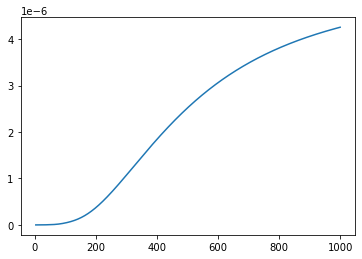

In [7]:
T=np.linspace(0,1000,1000)
plt.plot(T,Einstein_model(1)(T))

<lambdifygenerated-16>:2: RuntimeWarning: overflow encountered in exp
  return (0.00493510934/(exp(2117.8/T) - 1) + 0.00331744821/(exp(1237.9/T) - 1) + 0.0001456816/(exp(548.5/T) - 1) + 1.52928e-6/(exp(159.3/T) - 1))


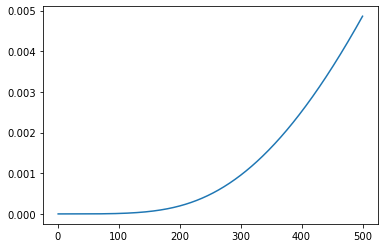

In [13]:
T=np.linspace(1,500,500)
plt.plot(T,10.7019289199415102*Einstein_model(2)(T))

In [ ]:
def Gauss(x, xc, A, sigma):
    return A / (sigma * np.sqrt(2 * np.pi)) * np.exp(-(x - xc) ** 2 / (2 * sigma ** 2))

In [ ]:
if __name__ == '__main__':
    logging.basicConfig(filename="444.log", level=logging.INFO)
    K = 8.6173e-05
    C = 239.203931
    mass, freq, mode, modewom = read_yaml("band.yaml")
    for i in range(len(freq)):
        logging.info(f"mode {i} freq {freq[i]} eV")
    ground = poscar.poscar()
    ground.read("POSCAR")
    ground.d2c()
    natom = len(ground.position)
    logging.info(f"number of atom is {natom}")

    # atom_list = [1, 2, 92, 32, 57, 55]
    # atom_list = [1,
    #              2,3,4,
    #              153,156,280,294,409,421,
    #              27,30,42,
    #              232,235,347,362,474,486,
    #              231,346,470]
    atom_list = [1, 2, 153, 27, 232, 231, ]

    pat = 3
    # nmode = 3
    # displacement = 0.1
    if pat == 8:
        # 分解随机位移测试

        ground_c2d = ground.copy()
        ground_c2d.c2d()
        energy0 = get_energy("d0_0")
        # omega 就是声子能量
        # print(sum(freq) / 2)

        for j in [0.01, 0.05, 0.1]:
            for i in range(5):
                path = f"r{j}_{i}"
                rp = poscar.poscar()
                rp.read(path + "/CONTCAR")
                distort = (rp - ground_c2d)
                distort.d2c()
                energy = 0
                # 包含了虚频模
                #for nmode in range(len(mode)):
                # 未包含虚频模
                for nmode in range(len(mode))[3:]:
                    proj_on_specific_mode = sum([distort.position[natom].dot(mode[nmode][natom]) * np.sqrt(mass[natom]) for natom in
                                                 range(len(mass))])
                    # print(nmode, proj_on_specific_mode ** 2)
                    energy += (proj_on_specific_mode * freq[nmode]) ** 2
                energy *= C / 2
                print(energy, get_energy(path) - energy0)

    elif pat == 4:
        for i in range(5):
            random_sub(0.1, i)
            random_sub(0.05, i)
            random_sub(0.01, i)

    elif pat == 1:
        for dir in os.listdir():
            if dir[0] == 'p' and os.path.isdir(dir):
                # 1. jobid
                # 2. '.log'
                # 3. ' writing wavefunctions'
                if os.path.isfile(f"{dir}/jobid"):
                    with open(f"{dir}/jobid", "r") as jobid:
                        lines = jobid.readlines()
                    jobid = lines[-1].split("<")[1].split(">")[0]
                    if os.path.isfile(f"{dir}/{jobid}.log"):
                        with open(f"{dir}/{jobid}.log", "r") as log:
                            lines = log.readlines()
                        if lines and lines[-1] and 'writing wavefunctions' in lines[-1]:
                            case = "good"
                        else:
                            case = "bad end"
                    else:
                        case = "no log"
                else:
                    case = "no jobid"

                if case in ["bad end", "no jobid"]:
                    scc_lib.linux_command(f"rm {dir} -r")

        for nmode in range(2000)[3:]:
            if float([i for i in scc_lib.linux_command("lfs quota -h ~")[2].split(" ") if i][1].split("G")[0]) > 960:
                # if float(scc_lib.linux_command("du -sh")[0].split("G")[0]) > 150:
                for dir in os.listdir():
                    if os.path.isdir(dir) and len(os.listdir(dir)) == 19:
                        # 4598164.log DOSCAR IBZKPT jobid
                        # OSZICAR PCDAT POTCAR vasprun.xml
                        # CONTCAR EIGENVAL INCAR KPOINTS
                        # OUTCAR POSCAR REPORT XDATCAR
                        # WAVECAR CHG CHGCAR
                        scc_lib.linux_command(f"rm {dir}/WAVECAR {dir}/CHG*")

            mode_sub(nmode, 0.25, "p")

        # for nmode in set(sum(dominant_term_dict.values(), [])):
        #     for displacement in [0.02, 0.04, 0.06, 0.07, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6,
        #                      0.7, 0.8, 0.9, 1]:
        #         # number_of_phonon_for_specfic_mode=1 / (np.exp(freq[nmode] / (K * 300)) - 1)
        #         # mode_sub(nmode, np.sqrt(2 * (number_of_phonon_for_specfic_mode + 0.5) / freq[nmode] / C))
        #         mode_sub(nmode, displacement)
        # lattice_list = [round(10.7+i*0.002,3) for i in range(25)]
        # lattice_list = [70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82]

        # lattice_list = [70, 70.5, 71, 71.5, 72, 72.5, 73, 73.5, 74, 74.5, 75, 75.5, 76, 76.5, 77, 77.5, 78]
        # for i in lattice_list:
        #     expand_sub(i)

    elif pat == 2:
        # 晶格膨胀
        # lattice_list = [round(10.7 + i * 0.002, 3) for i in range(25)]
        lattice_list = [70, 70.5, 71, 71.5, 72, 72.5, 73, 73.5, 74, 74.5, 75, 75.5, 76, 76.5, 77, 77.5, 78]
        # [i for i in range(83)[70:]]
        total_A_lattice = {atom: [] for atom in atom_list}
        Fermi_contact_term_lattice = {atom: [] for atom in atom_list}
        for lattice in lattice_list:
            total_A, Fermi_contact_term = read_outcar(f"s{lattice}", atom_list, natom, only_total=False, multi=100)
            for atom in atom_list:
                total_A_lattice[atom].append(total_A[atom])
                Fermi_contact_term_lattice[atom].append(Fermi_contact_term[atom])
        lattice_list = np.array(lattice_list)
        lattice_list = (10 + lattice_list / 100) / 3 * 4
        for atom in atom_list:
            x = np.linspace(min(lattice_list), max(lattice_list), 100)

            total_A_coef = np.polyfit(lattice_list, total_A_lattice[atom], 1)
            logging.info(f"{atom} fit {total_A_coef[0]}")
            print(f"{atom} fit {total_A_coef[0]}")

            # print(np.polyfit(lattice_list, total_A_lattice[atom], 1,full=True))

            Fermi_contact_term_coef = np.polyfit(lattice_list, Fermi_contact_term_lattice[atom], 1)
            logging.info(f"{atom} fit {Fermi_contact_term_coef[0]}")
            print(f"{atom} fit {Fermi_contact_term_coef[0]}")

            # print(np.polyfit(lattice_list, Fermi_contact_term_lattice[atom], 1,full=True))

            fig = plt.figure()
            ax1 = fig.add_subplot(111)
            ax1.scatter(lattice_list, total_A_lattice[atom])
            logging.info(f"fig1 ax1 scatter x {lattice_list}")
            logging.info(f"fig1 ax1 scatter y1 {total_A_lattice[atom]}")
            ax1.plot(x, np.poly1d(total_A_coef)(x), label="total")
            logging.info(f"fig1 ax1 plot x {x}")
            logging.info(f"fig1 ax1 plot y1 {np.poly1d(total_A_coef)(x)} label=total")
            ax1.scatter(lattice_list, Fermi_contact_term_lattice[atom])
            logging.info(f"fig1 ax1 scatter x {lattice_list}")
            logging.info(f"fig1 ax1 scatter y2 {Fermi_contact_term_lattice[atom]}")
            ax1.plot(x, np.poly1d(Fermi_contact_term_coef)(x), label="Fermi contact")
            logging.info(f"fig1 ax1 plot x {x}")
            logging.info(f"fig1 ax1 plot y2 {np.poly1d(Fermi_contact_term_coef)(x)} label=Fermi contact")
            ax2 = ax1.twiny()
            ax1.set_xlabel(r'$a$ ($\rm \AA$)', fontsize=15)
            ax1.set_ylabel("$A$ (MHz)", fontsize=15)
            y_min, y_max = ax1.get_ylim()
            y_min -= 0.1 * (y_max - y_min)
            y_max += 0.1 * (y_max - y_min)
            interval = float("%.1g" % ((y_max - y_min) / 4))
            ax1.set_yticks(np.arange(round(y_min / interval) * interval, round(y_max / interval) * interval + interval,
                                     step=interval), fontsize=15)
            ax1.set_ylim([y_min, y_max])
            # 10.693999999999999, 10.826
            # 0, 1
            # print(ax1.get_xlim())

            ax2.set_xticks(
                (np.array([10.7067892718930, 10.7258805001931, 10.7503068085486,
                           10.7765410039660, ]) - 10.693999999999999) / (10.826 - 10.693999999999999),
                ["500", "1000", "1500", "2000"], fontsize=15)
            ax2.tick_params(direction="in")
            ylim = ax1.get_ylim()
            ax1.plot([10.7019289199415 / 3 * 4, 10.7019289199415 / 3 * 4], ylim, "--")
            ax1.set_ylim(ylim)
            ax2.set_xlabel("$T$ (K)", fontsize=15)
            ax1.minorticks_on()
            ax1.legend(fontsize=15)
            ax1.tick_params(axis='both', which='major', labelsize=15)
            # ax2.tick_params(lattice='both', which='major', labelsize=15)
            plt.subplots_adjust(left=0.17, right=0.95, top=0.87, bottom=0.13)
            plt.savefig(f"lattice_fit_{atom}.pdf", dpi=600, format="pdf")
            plt.close("all")

    elif pat == 3:
        # 振动1
        # atom_list = [1, 2, 92, 32, 57, 55]
        # relax
        # expand_dict = {1: -0.14890109890108946,
        #                2: -49.128574909854834,
        #                92: 2.484024170945024,
        #                32: 3.379439422635399,
        #                57: -3.620531879907429,
        #                55: -1.3553078631494433, }
        # with 4\times4\times4
        expand_dict = {1: -0.09733823529411631,
                       2: -36.02762342878353,
                       153: 1.7437037436486906,
                       27: 2.1418375610626548,
                       232: -2.4736870204068118,
                       231: -0.6619703385867863, }

        # for i,j in list(zip([[1],
        # [2, 3, 4],
        # [153, 156, 280, 294, 409, 421],
        # [27, 30, 42],
        # [232, 235, 347, 362, 474, 486],
        # [231, 346, 470]],expand_dict)):
        #     for k in i:
        #         expand_dict[k]=expand_dict[j]

        # expand_dict = {1: -0.20313846153147483,
        #                2: -52.7965713764713,
        #                92: 2.2304546331594426,
        #                32: 3.0989269527201215,
        #                57: -3.258994926866736,
        #                55: -0.9349598940438555, }

        # static
        # expand_dict = {1: -0.6313, 2: 22.56, 92: 0.3877, 32: 0.2353, 57:0.5106, 55:-0.3804}
        #  a0 = 10.6826953888
        a0 = 14.2565920252871337
        polynomial_expand_dict = {1: [a0 * 1.30E-14, 0, 0, 0, 0],
                                  2: [2.74e-16, -1.62e-13, 5.79e-11, -6.98e-9, 2.99e-7, 0]}

        total_A_dict = {}
        Fermi_contact_term_dict = {}
        energy_dict = {}
        emass = []
        total_a2q2 = {atom: {} for atom in atom_list}
        Fermi_contact_a2q2 = {atom: {} for atom in atom_list}

        # read A matrix from eq structure
        total_A0, Fermi_contact_term0 = read_outcar("p0_0", atom_list, natom, only_total=False, multi=100,
                                                    printlevel=True)

        # for atom in total_A0:
        #     total_A0[atom] = proj_tensor(total_A0[atom], vector, 100)
        #     print(atom, total_A0[atom])
        #     logging.info(f"A for atom {atom} is {total_A0[atom]}")

        energy0 = get_energy("d0_0")

        for nmode in range(len(mode))[3:]:
            # 某模式单个声子对应的温度 freq[nmode] / np.log(2) / K K 和振幅 np.sqrt(2 / freq[nmode] / C) amu^(1/2)A
            # 300K 对应的声子数 number_of_phonon_for_specfic_mode = 1 / (np.exp(freq[nmode] / (K * 300)) - 1)
            # 和振幅 np.sqrt(2 * number_of_phonon_for_specfic_mode / freq[nmode] / C) amu^(1/2)A

            energy_dict[nmode] = {}
            total_A_dict[nmode] = {}
            Fermi_contact_term_dict[nmode] = {}
            dir_list = [dir for dir in os.listdir() if os.path.isdir(dir) and f"p{nmode}_" in dir]

            # 读 hyperfine 和能量

            for dir in dir_list:
                displacement = float(dir.split("_")[1])
                total_A_dict[nmode][displacement], \
                Fermi_contact_term_dict[nmode][displacement] = read_outcar(dir, atom_list, natom, only_total=False,
                                                                           multi=100)
                energy_dict[nmode][displacement] = get_energy(dir)

            total_A_dict[nmode][0] = total_A0
            Fermi_contact_term_dict[nmode][0] = Fermi_contact_term0
            energy_dict[nmode] = {displacement: energy_dict[nmode][displacement] - energy0 for displacement in
                                  energy_dict[nmode]}
            energy_dict[nmode][0] = 0

            # 测试有效质量是否收敛
            if False:
                for displacement in energy_dict[nmode]:
                    print(f"calculated {energy_dict[nmode][displacement]} eV"
                          f"expected {(freq[nmode] * displacement) ** 2 / 2 * C} eV")
                mass_coef = np.polyfit(list(energy_dict[nmode].keys()), list(energy_dict[nmode].values()), 2)
                x = np.linspace(min(energy_dict[nmode].keys()), max(energy_dict[nmode].keys()), 100)

                fig = plt.figure()
                ax = fig.add_subplot(111)
                ax.scatter(energy_dict[nmode].keys(), energy_dict[nmode].values())
                ax.plot(x, np.poly1d(mass_coef)(x), label="fitting")
                ax.plot(x, (freq[nmode] * x) ** 2 / 2 * C, label="harmonic")

                # +声子波函数
                number_of_phonon = 0
                while True:
                    if freq[nmode] * (number_of_phonon + 0.5) > np.poly1d(mass_coef)(x[-1]):
                        break
                    else:
                        ax.plot(x[0::len(x) - 1],
                                [freq[nmode] * (number_of_phonon + 0.5), freq[nmode] * (number_of_phonon + 0.5)],
                                "--")
                        x2 = x * (freq[nmode] * C) ** 0.5
                        phonon_wf = np.e ** (-x2 ** 2 / 2) \
                                    * np.polynomial.hermite.hermval(x2, [0 if _ < number_of_phonon
                                                                         else 1 for _ in range(number_of_phonon + 1)])
                        # 归一化, 0.25 跟据显示效果可以调整
                        ax.plot(x,
                                .25 * freq[nmode] / (sum(phonon_wf ** 2) * (x[-1] - x[0]) / len(x)) ** 0.5 * phonon_wf \
                                + freq[nmode] * (number_of_phonon + 0.5))
                        number_of_phonon += 1

                ax.set_xlabel(r'$X$ ($\rm \sqrt{amu}\cdot\AA$)', fontsize=15)
                ax.set_ylabel("Energy (eV)", fontsize=15)
                y_min, y_max = ax.get_ylim()
                interval = float("%.1g" % ((y_max - y_min) / 4))
                ax.set_yticks(np.arange(round(y_min / interval) * interval,
                                        round(y_max / interval) * interval + interval, step=interval))
                ax.set_ylim([y_min, y_max])
                ax.minorticks_on()
                ax.tick_params(axis='both', which='major', labelsize=15)
                plt.subplots_adjust(top=0.87, bottom=0.13, left=0.17, right=0.95)
                plt.title(f"mass_check_for_mode{nmode}")
                plt.legend()
                plt.savefig(f"mass_{nmode}.pdf", dpi=600, format="pdf")
                plt.close("all")

            for atom in atom_list:
                x = np.linspace(min(total_A_dict[nmode].keys()), max(total_A_dict[nmode].keys()))
                total_A_coef = np.polyfit(list(total_A_dict[nmode].keys()),
                                          [total_A_dict[nmode][displacement][atom] for displacement in
                                           total_A_dict[nmode]],
                                          2)
                Fermi_contact_term_coef = np.polyfit(list(Fermi_contact_term_dict[nmode].keys()),
                                                     [Fermi_contact_term_dict[nmode][displacement][atom] for
                                                      displacement in
                                                      Fermi_contact_term_dict[nmode]], 2)

                # fig = plt.figure()
                # ax = fig.add_subplot(111)
                # ax.scatter(total_A_dict[nmode].keys(),
                #            [total_A_dict[nmode][displacement][atom] for displacement in total_A_dict[nmode]])
                # ax.scatter(Fermi_contact_term_dict[nmode].keys(),
                #            [Fermi_contact_term_dict[nmode][displacement][atom] for displacement in
                #             Fermi_contact_term_dict[nmode]])
                #
                # ax.plot(x, np.poly1d(total_A_coef)(x), label="total")
                # ax.plot(x, np.poly1d(Fermi_contact_term_coef)(x), label="Fermi contact")
                # ax.set_xlabel(r'$X$ ($\rm \sqrt{amu}\cdot\AA$)', fontsize=15)
                # ax.set_ylabel("$A$ (MHz)", fontsize=15)
                # y_min, y_max = ax.get_ylim()
                # interval = float("%.1g" % ((y_max - y_min) / 4))
                # ax.set_yticks(np.arange(round(y_min / interval) * interval,
                #                         round(y_max / interval) * interval + interval, step=interval))
                # ax.set_ylim([y_min, y_max])
                # plt.title(f"hyperfine_check_for_mode{nmode}_and_atom{atom}")
                # ax.minorticks_on()
                # ax.legend(fontsize=15)
                # ax.tick_params(axis='both', which='major', labelsize=15)
                # plt.subplots_adjust(top=0.87, bottom=0.13, left=0.17, right=0.95)
                # plt.savefig(f"hyperfine_{nmode}_{atom}.pdf", dpi=600, format="pdf")
                # plt.close("all")

                # 在 0 处的二阶导, assuming A = a * x ** 2, A''|0 = 2 * a
                # np.polyval(np.polyder(np.polyder(total_A_coef)), 0)
                # np.polyval(np.polyder(np.polyder(Fermi_contact_term_coef)), 0)
                # for specific displacement, 2 * a =
                # (total_A_dict[nmode][displacement][atom]
                # + total_A_dict[nmode][displacement * -1][atom] - 2 * total_A0[atom])
                # / displacement ** 2

                total_a2q2[atom][nmode] = np.polyval(np.polyder(np.polyder(total_A_coef)), 0)
                Fermi_contact_a2q2[atom][nmode] = np.polyval(np.polyder(np.polyder(Fermi_contact_term_coef)), 0)

        # freq = freq[3:]
        # logging.info(f"3 removed {len(freq)} remain, freq start from {freq[0]} to {freq[-1]}")
        # 300 K 对应 t[289]
        t = np.linspace(11, 500, 490)

In [ ]:
#         Einstein_model_expand_list = []
#         Einstein_model_expand = 0
#         for i in t:
#             Einstein_model_expand += Einstein_model(i - 0.5)
#             Einstein_model_expand_list.append(Einstein_model_expand)
#         Einstein_model_expand_list = np.array(Einstein_model_expand_list)

        number_of_phonon_for_specfic_mode = {nmode: 1 / (np.exp(freq[nmode] / (K * t)) - 1) for nmode in
                                             range(len(mode))[3:]}
        number_of_phonon_for_specfic_mode_at_300K = {nmode: 1 / (np.exp(freq[nmode] / (K * 300)) - 1) for nmode in
                                                     range(len(mode))[3:]}

        for atom in atom_list:
            total_a2 = np.zeros(len(t))
            total_a2_300 = {}
            total_a2t = np.zeros(len(t))
            Fermi_contact_a2 = np.zeros(len(t))
            Fermi_contact_a2t = np.zeros(len(t))

            for nmode in range(len(mode))[3:]:
                # A_mode = (number_of_phonon_for_specfic_mode[nmode] + 0.5)/ 2  * a2q2[atom][nmode]/ (freq[nmode] * C)

                # A_mode = total_a2q2[atom][nmode] / freq[nmode] / C
                # delta_x = (freq[-1] - freq[0]) / 1530 * 2
                # ax1_y += Gauss(ax1_x, freq[nmode], 2 * A_mode * delta_x, delta_x / np.sqrt(2 * np.pi))
                # A_mode = number_of_phonon_for_specfic_mode[nmode] / 2 * A_mode

                # logging.info(f"mode_contribution {nmode} {atom} {A_mode[289]} {abs(A_mode[289])}")
                total_a2_300[nmode] = number_of_phonon_for_specfic_mode_at_300K[nmode] / 2 * total_a2q2[atom][nmode] / \
                                      freq[nmode] / C
                total_a2 += number_of_phonon_for_specfic_mode[nmode] / 2 * total_a2q2[atom][nmode] / freq[nmode] / C
                total_a2t += (number_of_phonon_for_specfic_mode[nmode] + 1) * number_of_phonon_for_specfic_mode[nmode] \
                             / K / np.power(t, 2) / C * total_a2q2[atom][nmode] / 2

                Fermi_contact_a2 += number_of_phonon_for_specfic_mode[nmode] / 2 / (freq[nmode] * C) * \
                                    Fermi_contact_a2q2[atom][nmode]
                Fermi_contact_a2t += (number_of_phonon_for_specfic_mode[nmode] + 1) * number_of_phonon_for_specfic_mode[
                    nmode] / K / np.power(t, 2) / C * \
                                     Fermi_contact_a2q2[atom][nmode] / 2

            # top 10 contribution
            print(f"atom{atom} contribution")
            for nmode,a2 in sorted(list(total_a2_300.items()), key=lambda x:abs(x[1]), reverse=True)[:10]:
                print(f"mode{nmode} contribution {a2*1000} kHz percentage {abs(a2)/total_a2[289]}")

                # 测试 A 差分导数是否收敛
                x = np.linspace(min(total_A_dict[nmode].keys()), max(total_A_dict[nmode].keys()))
                total_A_coef = np.polyfit(list(total_A_dict[nmode].keys()),
                                          [total_A_dict[nmode][displacement][atom] for displacement in
                                           total_A_dict[nmode]],
                                          2)
                Fermi_contact_term_coef = np.polyfit(list(Fermi_contact_term_dict[nmode].keys()),
                                                     [Fermi_contact_term_dict[nmode][displacement][atom] for
                                                      displacement in
                                                      Fermi_contact_term_dict[nmode]], 2)

                fig = plt.figure()
                ax = fig.add_subplot(111)
                ax.scatter(total_A_dict[nmode].keys(),
                           [total_A_dict[nmode][displacement][atom] for displacement in total_A_dict[nmode]])
                ax.scatter(Fermi_contact_term_dict[nmode].keys(),
                           [Fermi_contact_term_dict[nmode][displacement][atom] for displacement in
                            Fermi_contact_term_dict[nmode]])

                ax.plot(x, np.poly1d(total_A_coef)(x), label="total")
                ax.plot(x, np.poly1d(Fermi_contact_term_coef)(x), label="Fermi contact")
                ax.set_xlabel(r'$X$ ($\rm \sqrt{amu}\cdot\AA$)', fontsize=15)
                ax.set_ylabel("$A$ (MHz)", fontsize=15)
                y_min, y_max = ax.get_ylim()
                interval = float("%.1g" % ((y_max - y_min) / 4))
                ax.set_yticks(np.arange(round(y_min / interval) * interval,
                                        round(y_max / interval) * interval + interval, step=interval))
                ax.set_ylim([y_min, y_max])
                plt.title(f"hyperfine_check_for_mode{nmode}_and_atom{atom}")
                ax.minorticks_on()
                ax.legend(fontsize=15)
                ax.tick_params(axis='both', which='major', labelsize=15)
                plt.subplots_adjust(top=0.87, bottom=0.13, left=0.17, right=0.95)
                plt.savefig(f"hyperfine_{nmode}_{atom}.pdf", dpi=600, format="pdf")
                plt.close("all")

            fig = plt.figure()
            ax1 = fig.add_subplot(111)
            plt.subplots_adjust(right=0.87)

            ax1_ymax = 0
            ax1_ymin = 0
            for nmode in range(len(mode))[3:]:
                # 1000 for MHz to kHz
                ax1_y = total_a2q2[atom][nmode] / freq[nmode] / C / 2 * 1000
                ax1_ymax = ax1_ymax if ax1_ymax > ax1_y else ax1_y
                ax1_ymin = ax1_ymin if ax1_ymin < ax1_y else ax1_y
                ax1.plot([freq[nmode], freq[nmode]], [0, ax1_y], "b")
            ax1.plot([freq[0] - (freq[-1] - freq[0]) * 0.02, freq[-1] + (freq[-1] - freq[0]) * 0.02], [0, 0], "k--")
            ax1.set_xlim([freq[0] - (freq[-1] - freq[0]) * 0.02, freq[-1] + (freq[-1] - freq[0]) * 0.02])
            ax1.set_ylim([ax1_ymin - (ax1_ymax - ax1_ymin) * 0.1, ax1_ymax + (ax1_ymax - ax1_ymin) * 0.1])
            ratio = (ax1_ymax + (ax1_ymax - ax1_ymin) * 0.1) / (ax1_ymax - ax1_ymin) / 1.2
            ax1.set_ylabel('$c^i$ (kHz)', fontsize=15)

            ax2 = ax1.twinx()
            ax2.plot(freq[3:], [1 / (np.exp(freq[nmode] / (K * 300)) - 1) for nmode in range(len(mode))[3:]],
                     label="300 K")
            ax2.plot(freq[3:], [1 / (np.exp(freq[nmode] / (K * 500)) - 1) for nmode in range(len(mode))[3:]],
                     label="500 K")

            ax2_max = 1 / (np.exp(freq[0] / (K * 500)) - 1)
            ax2.set_ylim([ax2_max * 1.01 * (1 - 1 / ratio), ax2_max * 1.01])
            ax2.set_yticks(np.arange(0, .5, step=0.2), fontsize=15)
            ax2.yaxis.set_ticks_position('left')
            ax1.yaxis.set_ticks_position('right')
            ax2.yaxis.set_label_position('left')
            ax1.yaxis.set_label_position('right')
            ax1.tick_params(direction="in")
            ax1.minorticks_on()
            ax2.minorticks_on()
            ax2.set_ylabel(r'$ \bar n$', fontsize=15)
            ax1.set_xlabel('$\hbar\omega$ (eV)', fontsize=15)
            ax1.tick_params(axis='both', which='major', labelsize=15)
            ax2.tick_params(axis='both', which='major', labelsize=15)
            plt.subplots_adjust(right=0.83, top=0.87, bottom=0.13)
            plt.legend(fontsize=15)
            plt.title(f'contribution_for_atom{atom}')
            plt.savefig(f'contribution_{atom}.pdf', dpi=600, format="pdf")

            fig = plt.figure()
            ax = fig.add_subplot(111)
            plt.subplots_adjust(left=0.13)
            a1 = expand_dict[atom] * a0 * Einstein_model(2)(t)
            ax.plot(t, a1 * 1000, label="static")
            ax.plot(t, Fermi_contact_a2 * 1000, label="Fermi contact")
            ax.plot(t, total_a2 * 1000, label="dynamic")
            ax.plot(t, (a1 + total_a2) * 1000, label="total")
            print(f"{atom} tot {a1[289] + total_a2[289]} stc {a1[289]} dyn {total_a2[289]} ({Fermi_contact_a2[289]})")
            ax.set_xlabel('$T$ (K)', fontsize=15)
            ax.set_ylabel(r'$\delta A$ (kHz)', fontsize=15)
            y_min, y_max = ax.get_ylim()
            interval = float("%.1g" % ((y_max - y_min) / 4))
            ax.set_yticks(
                np.arange(round(y_min / interval) * interval, round(y_max / interval) * interval + interval,
                          step=interval))
            ax.set_ylim([y_min, y_max])
            ax.minorticks_on()
            ax.legend(fontsize=15)
            ax.tick_params(axis='both', which='major', labelsize=15)
            plt.subplots_adjust(top=0.87, bottom=0.13, left=0.16)
            plt.savefig(f'at_{atom}.pdf', dpi=600, format="pdf")

            fig = plt.figure()
            ax = fig.add_subplot(111)
            plt.subplots_adjust(left=0.16)
            a1t = expand_dict[atom] * a0 * Einstein_model(1)(t)
            ax.plot(t, a1t * 1e3, label="static")
            ax.plot(t, Fermi_contact_a2t * 1e3, label="Fermi contact")
            ax.plot(t, total_a2t * 1e3, label="dynamic")
            ax.plot(t, (a1t + total_a2t) * 1e3, label="total")
            print(
                f"{atom} tot {a1t[289] + total_a2t[289]} stc {a1t[289]} dyn {total_a2t[289]} ({Fermi_contact_a2t[289]})")
            ax.set_xlabel('$T$ (K)', fontsize=15)
            ax.set_ylabel(r"$A'(T)$ (kHz/K)", fontsize=15)
            y_min, y_max = ax.get_ylim()
            interval = float("%.1g" % ((y_max - y_min) / 4))
            ax.set_yticks(
                np.arange(round(y_min / interval) * interval, round(y_max / interval) * interval + interval,
                          step=interval))
            ax.set_ylim([y_min, y_max])

            ax.minorticks_on()
            ax.legend(fontsize=15)
            ax.tick_params(axis='both', which='major', labelsize=15)
            plt.subplots_adjust(top=0.87, bottom=0.13)
            plt.savefig(f'att_{atom}.pdf', dpi=600, format="pdf")
            plt.close("all")

    elif pat == 5:
        # 晶格膨胀
        lattice_list = [i for i in range(83)[70:]]
        Cq_expand = []
        for lattice in lattice_list:
            Cq_expand.append(read_Cq(f"p{lattice}"))
        lattice_list = np.array(lattice_list)
        lattice_list = 10 + lattice_list / 100

        x = np.linspace(min(lattice_list), max(lattice_list), 100)

        Cq_expand_coef = np.polyfit(lattice_list, Cq_expand, 1)
        print(f"Cq fit {Cq_expand_coef[0]}")

        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        ax1.scatter(lattice_list, Cq_expand)
        logging.info(f"fig1 ax1 scatter x {lattice_list}")
        logging.info(f"fig1 ax1 scatter y1 {Cq_expand}")
        ax1.plot(x, np.poly1d(Cq_expand_coef)(x))
        logging.info(f"fig1 ax1 plot x {x}")
        logging.info(f"fig1 ax1 plot y1 {np.poly1d(Cq_expand_coef)(x)}")

        ax2 = ax1.twiny()
        ax1.set_xlabel(r'$a$ ($\rm \AA$)', fontsize=15)
        ax1.set_ylabel("$A$ (MHz)", fontsize=15)
        y_min, y_max = ax1.get_ylim()
        y_min -= 0.1 * (y_max - y_min)
        y_max += 0.1 * (y_max - y_min)
        interval = float("%.1g" % ((y_max - y_min) / 4))
        ax1.set_yticks(
            np.arange(round(y_min / interval) * interval, round(y_max / interval) * interval + interval, step=interval),
            fontsize=15)
        ax1.set_ylim([y_min, y_max])
        # 10.693999999999999, 10.826
        # 0, 1
        # print(ax1.get_xlim())

        ax2.set_xticks((np.array(
            [10.7067892718930, 10.7258805001931,
             10.7503068085486, 10.7765410039660, ]) - 10.693999999999999) / (
                               10.826 - 10.693999999999999),
                       ["500", "1000",
                        "1500", "2000"], fontsize=15)
        ax2.tick_params(direction="in")
        ylim = ax1.get_ylim()
        ax1.plot([10.7019289199415, 10.7019289199415], ylim, "--")
        ax1.set_ylim(ylim)
        ax2.set_xlabel("$T$ (K)", fontsize=15)
        ax1.minorticks_on()
        ax1.legend(fontsize=15)
        ax1.tick_params(axis='both', which='major', labelsize=15)
        # ax2.tick_params(lattice='both', which='major', labelsize=15)
        plt.subplots_adjust(left=0.17, right=0.95, top=0.87, bottom=0.13)
        plt.savefig(f"Cq_expand_fit_.pdf", dpi=600, format="pdf")
        plt.close("all")

    elif pat == 6:
        Cq_expand_coef = -0.4901098901098642
        a0 = 10.7019289199415102
        polynomial_expand_dict = {1: [a0 * 1.30E-14, 0, 0, 0, 0],
                                  2: [2.74e-16, -1.62e-13, 5.79e-11, -6.98e-9, 2.99e-7, 0]}

        Cq_dict = {}
        energy_dict = {}
        emass = []
        Cq2q2 = []

        # read A matrix from eq structure
        total_Cq0 = read_Cq("p0_0")
        energy0 = get_energy("p0_0")

        for nmode in range(len(mode))[3:]:
            # 单声子温度/振幅
            logging.info(f"{nmode} {freq[nmode] / np.log(2) / K} K {np.sqrt(2 / freq[nmode] / C)} amu^(1/2)A")
            # 300K 声子数/振幅
            number_of_phonon_for_specfic_mode = 1 / (np.exp(freq[nmode] / (K * 300)) - 1)
            logging.info(
                f"{nmode} {number_of_phonon_for_specfic_mode} {np.sqrt(2 * number_of_phonon_for_specfic_mode / freq[nmode] / C)} amu^(1/2)A")

            energy_dict[nmode] = {}
            Cq_dict[nmode] = {}

            # get A from 1
            displacement = 0.5
            for i in [-1, 1]:
                Cq_dict[nmode][displacement * i] = read_Cq(f"p{nmode}_{displacement * i}")

            Cq2q2.append(
                (Cq_dict[nmode][displacement] + Cq_dict[nmode][displacement * -1] - 2 * total_Cq0) / displacement ** 2)

        #freq = freq[3:]
        logging.info(f"moved freq check {freq[0]} {len(freq)}")
        t = np.linspace(11, 500, 490)
        number_of_phonon_for_specfic_mode = [1 / (np.exp(freq[nmode] / (K * t)) - 1) for nmode in range(len(mode))[3:]]

#         Einstein_model_expand_list = []
#         Einstein_model_expand = 0
#         for i in t:
#             Einstein_model_expand += Einstein_model(i - 0.5)
#             Einstein_model_expand_list.append(Einstein_model_expand)
#         Einstein_model_expand_list = np.array(Einstein_model_expand_list)

        Cq2 = np.zeros(len(t))
        Cq2t = np.zeros(len(t))
        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        plt.subplots_adjust(right=0.87)
        ax1_x = np.arange(freq[0], freq[-1], step=(freq[-1] - freq[0]) / 642 / 3)
        ax1_y = np.zeros(len(ax1_x))
        for nmode in range(len(mode) - 3):
            Cq_mode = Cq2q2[nmode] / freq[nmode] / C
            delta_x = (freq[-1] - freq[0]) / 642 * 2
            ax1_y += Gauss(ax1_x, freq[nmode], 2 * Cq_mode * delta_x, delta_x / np.sqrt(2 * np.pi))
            Cq_mode = number_of_phonon_for_specfic_mode[nmode] / 2 * Cq_mode
            logging.info(f"mode_contribution {nmode} {Cq_mode[289]} {abs(Cq_mode[289])}")
            Cq2 += Cq_mode
            Cq2t += (number_of_phonon_for_specfic_mode[nmode] + 1) * number_of_phonon_for_specfic_mode[
                nmode] / K / np.power(t, 2) / C * Cq2q2[nmode] / 2

        ax1_y *= 1000
        ax1_max = max(ax1_y)
        ax1_min = min(ax1_y)
        ax1.plot(ax1_x, ax1_y, "b")
        logging.info(f"fig2 ax1 plot x ")
        for i in ax1_x:
            logging.info(f"{i} ")
        logging.info("\n")
        logging.info(f"fig2 ax1 plot y ")
        for i in ax1_y:
            logging.info(f"{i} ")
        logging.info("\n")
        ax1.plot([freq[0] - (freq[-1] - freq[0]) * 0.02, freq[-1] + (freq[-1] - freq[0]) * 0.02], [0, 0], "k--")
        ax1.set_xlim([freq[0] - (freq[-1] - freq[0]) * 0.02, freq[-1] + (freq[-1] - freq[0]) * 0.02])
        ax1.set_ylim([ax1_min - (ax1_max - ax1_min) * 0.1, ax1_max + (ax1_max - ax1_min) * 0.1])
        ratio = (ax1_max + (ax1_max - ax1_min) * 0.1) / (ax1_max - ax1_min) / 1.2
        ax1.set_ylabel('$c^i$ (kHz)', fontsize=15)
        ax2 = ax1.twinx()
        ax2.plot(freq, [1 / (np.exp(freq[nmode] / (K * 300)) - 1) for nmode in range(len(mode) - 3)],
                 label="300 K")
        ax2.plot(freq, [1 / (np.exp(freq[nmode] / (K * 500)) - 1) for nmode in range(len(mode) - 3)],
                 label="500 K")
        logging.info(f"fig2 ax2 plot x {freq}")
        logging.info(
            f"fig2 ax2 plot y1 {[1 / (np.exp(freq[nmode] / (K * 300)) - 1) for nmode in range(len(mode) - 3)]} label=300 K")
        logging.info(
            f"fig2 ax2 plot y2 {[1 / (np.exp(freq[nmode] / (K * 500)) - 1) for nmode in range(len(mode) - 3)]} label=500 K")
        ax2_max = 1 / (np.exp(freq[0] / (K * 500)) - 1)
        ax2.set_ylim([ax2_max * 1.01 * (1 - 1 / ratio), ax2_max * 1.01])
        ax2.set_yticks(np.arange(0, .5, step=0.2), fontsize=15)
        ax2.yaxis.set_ticks_position('left')
        ax1.yaxis.set_ticks_position('right')
        ax2.yaxis.set_label_position('left')
        ax1.yaxis.set_label_position('right')
        ax1.tick_params(direction="in")
        ax1.minorticks_on()
        ax2.minorticks_on()
        ax2.set_ylabel(r'$ \bar n$', fontsize=15)
        ax1.set_xlabel('$\hbar\omega$ (eV)', fontsize=15)
        ax1.tick_params(axis='both', which='major', labelsize=15)
        ax2.tick_params(axis='both', which='major', labelsize=15)
        plt.subplots_adjust(right=0.83, top=0.87, bottom=0.13)
        plt.legend(fontsize=15)
        plt.savefig(f'Cq_phonon.pdf', dpi=600, format="pdf")

        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.subplots_adjust(left=0.13)

        a1 = Cq_expand_coef * a0 * Einstein_model(2)(t)
        ax.plot(t, a1 * 1000, label="static")
        ax.plot(t, Cq2 * 1000, label="dynamic")
        ax.plot(t, (a1 + Cq2) * 1000, label="total")
        logging.info(f"fig3 ax plot x {t}")
        logging.info(f"fig3 ax plot y1 {a1 * 1000} label=static")
        logging.info(f"fig3 ax plot y3 {Cq2 * 1000} label=dynamic")
        logging.info(f"fig3 ax plot y4 {(a1 + Cq2) * 1000} label=total")

        print(a1[289], Cq2[289], a1[289] + Cq2[289])
        ax.set_xlabel('$T$ (K)', fontsize=15)
        ax.set_ylabel(r'$\delta Cq$ (kHz)', fontsize=15)
        y_min, y_max = ax.get_ylim()
        interval = float("%.1g" % ((y_max - y_min) / 4))
        ax.set_yticks(
            np.arange(round(y_min / interval) * interval, round(y_max / interval) * interval + interval,
                      step=interval))
        ax.set_ylim([y_min, y_max])
        ax.minorticks_on()
        ax.legend(fontsize=15)
        ax.tick_params(axis='both', which='major', labelsize=15)
        plt.subplots_adjust(top=0.87, bottom=0.13, left=0.16)
        plt.savefig(f'Cq.pdf', dpi=600, format="pdf")

        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.subplots_adjust(left=0.16)

        a1t = Cq_expand_coef * a0 * Einstein_model(1)(t)
        ax.plot(t, a1t * 1e3, label="static")
        ax.plot(t, Cq2t * 1e3, label="dynamic")
        ax.plot(t, (a1t + Cq2t) * 1e3, label="total")
        print(a1t[289], Cq2t[289], a1t[289] + Cq2t[289])
        ax.set_xlabel('$T$ (K)', fontsize=15)
        ax.set_ylabel(r"$Cq'(T)$ (kHz/K)", fontsize=15)
        y_min, y_max = ax.get_ylim()
        interval = float("%.1g" % ((y_max - y_min) / 4))
        ax.set_yticks(
            np.arange(round(y_min / interval) * interval, round(y_max / interval) * interval + interval,
                      step=interval))
        ax.set_ylim([y_min, y_max])
        ax.minorticks_on()
        ax.legend(fontsize=15)
        ax.tick_params(axis='both', which='major', labelsize=15)
        plt.subplots_adjust(top=0.87, bottom=0.13)
        plt.savefig(f'Cqt.pdf', dpi=600, format="pdf")
        plt.close("all")